# Predicting Stroke Events using Machine Learning 

Recently I've been fascinated by machine learning and decided to dive more into this world to learn what it is all about. I've taken a course on using the Scikit-learn library through Python and coupled with my previous experience (w/pandas, matplotlib, numpy, & seaborn), I wanted to try and tackle a ML project. (I've also upped my markdown game from previous notebooks, which I want to showcase a bit as well.)

The project I'm going to do in this notebook is to predict whether or not a patient had a stroke based on a number of medical and personal attributes. The intent is to use this ml model to predict the likelihood of a stroke in future patients. This will be a classification model as we're trying to predict whether a patient falls into the category of "Stroke" or "No Stroke". So without further ado, let's get started! 

## Problem Definition: 

> Given clinical and personal parameters about a patient, can we predict whether or not the patient had a stroke? 

## Data: 

I'm using the stroke-prediction-dataset by FEDESORIANO which can be found at this link: 

https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv

## Evaluation: 

This data isn't part of a competition, so there isn't a particular theshold that I'm trying to obtain with this ML model. Instead I'm just aiming for as high of an accuracy score as I can obtain in model predictions. But for the sake of professionalism, we'll define an arbitrary number to shoot for. 

> If the model can reach 95% or higher accuracy at predicting whether or not a patient has had a stroke, then we will consider this project a success. 

## Features: 

I've copied and pasted the dictionary for features from the original dataset page listed above. 

**Data Dictionary**

1) **id**: unique identifier

2) **gender**: "Male", "Female" or "Other"

3) **age**: age of the patient

4) **hypertension**: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) **heart_disease**: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) **ever_married**: "No" or "Yes"

7) **work_type**: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) **Residence_type**: "Rural" or "Urban"

9) **avg_glucose_level**: average glucose level in blood

10) **bmi**: body mass index

11) **smoking_status**: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12) **stroke**: 1 if the patient had a stroke or 0 if not

***Note**: "Unknown" in smoking_status means that the information is unavailable for this patient

# Preparing the tools 

I'm going to start by importing all of the python libraries that I will need for the duration of this project.

In [1]:
# EDA and plotting libraries 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 

# Scikit-Learn estimators 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression # Regression might seem counterintuitive, but we'll address this later
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# Model Evaluations
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score # Separate lines to keep everyting "Pythonic"
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 

# To handle warnings 
import warnings

# Loading Data


In [2]:
# Importing the CSV file 
df = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")

# Checking to make sure the import worked
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# Exploratory Data Analysis (EDA) 

Before we start training models, I want to look through the data and familiarize myself with it a bit. I want to check for missing values and non-numeric values, as the ml models I'll be using need to work with numeric data. I also want to check to see if there are any outliers that are skewing the dataset. We'll experiment for a while to get a feel for the data. 

In [3]:
# Getting a general feel for the data
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# I'm curious about the number of stroke(1) v. non-stroke(0) patients in the dataset 
df["stroke"].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

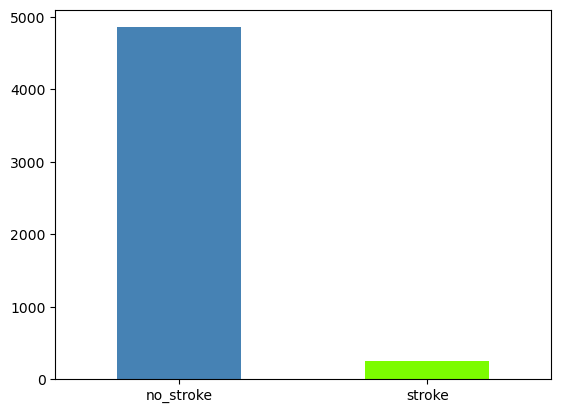

In [5]:
# Let's put this in a plot
st_plot = df["stroke"].value_counts().plot(kind="bar",color=["steelblue","lawngreen"], rot=0)
plt.xticks(ticks=[1,0], labels=["stroke", "no_stroke"]);

This seems problematic from the outset as the dataset is imbalanced. 249 / 5110 means less than 5% of all our data contains people who've actually had a stroke. That means the machine could predict "no_stroke" for every guess and still achieve around 95% accuracy. At this point in real life, I would contact whoever had given me the data and ask if they had more data available on patients who've had a stroke. I want to incorporate more stroke data to offset the imbalance and more accurately make predictions with my machine learning model. Since this is just a project for fun, I'm going to ignore this glaring error. 

In [6]:
# Let's look at the datatypes of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
# Checking for missing values 
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Since my models need numeric data, I'm going to have to do something with these object datatypes. I also will need to fill in the missing values on the "bmi" column. I'll do all of this after I finish my EDA and split the data. 

Next, I'm going to look to see how gender might affect stroke likeliness.

In [8]:
# Comparing gender with target (stroke) column
pd.crosstab(df.stroke, df.gender)

gender,Female,Male,Other
stroke,,,
0,2853,2007,1
1,141,108,0


Well it looks like we have a fairly even distribution of males and females that have and haven't had a stroke. There doesn't seem to be any indicators in the gender column that point one way or another. It does look like that there were almost 900 more females surveyed than men.

**Note**: 
Since I only have one "Other" value, I'm going to drop it from my dataset so it will be easier to aggregate and visualize the data. If I had numerous instances of "Other", then I would keep the data for consideration. 

In [9]:
# Finding out which row is Other
df[df["gender"] == "Other"]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [10]:
# Dropping the Other value
df.drop(df[df['id'] == 56156].index, inplace=True)

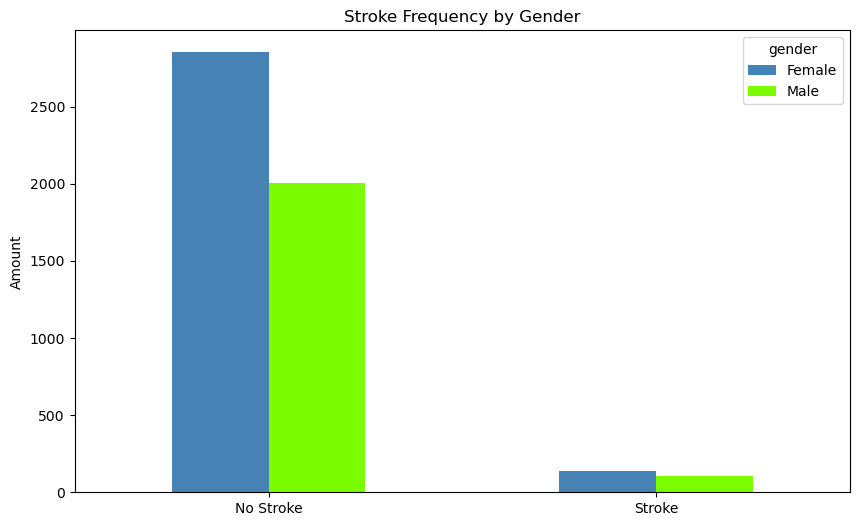

In [11]:
# Let's visualize the gender crosstab from above 
pd.crosstab(df.stroke, df.gender).plot(kind='bar',
                                       figsize=(10,6), 
                                       color=["steelblue","lawngreen"],
                                       rot=0)

# Styling
plt.title("Stroke Frequency by Gender")
plt.xticks(ticks=[0,1],labels=["No Stroke", "Stroke"])
plt.xlabel(None)
plt.ylabel("Amount");


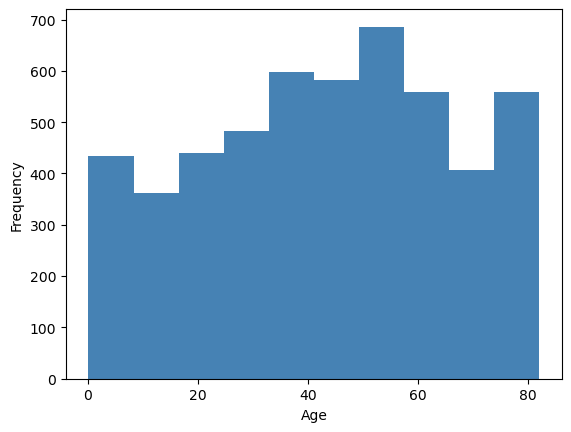

In [12]:
# Let's look at this distribution by ages 
df["age"].plot.hist(color="steelblue")
plt.xlabel("Age");

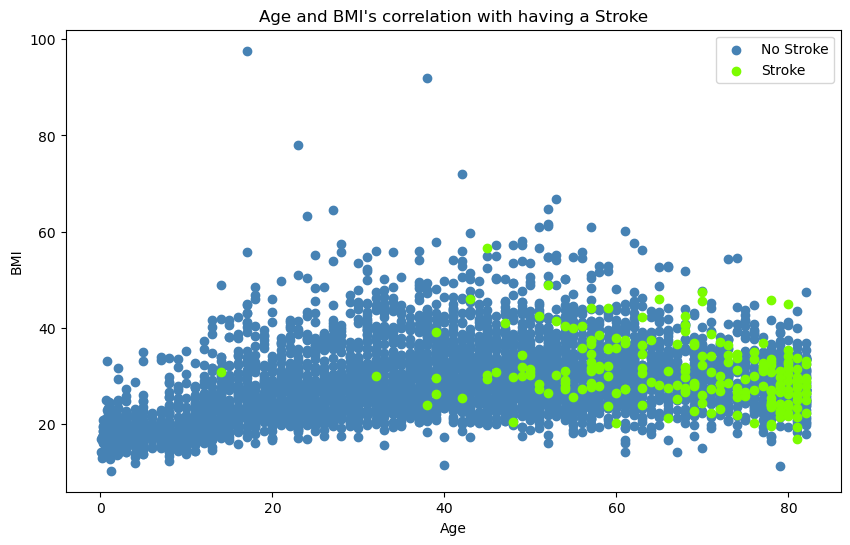

In [13]:
plt.figure(figsize=(10,6))

# Ages and BMI for people who haven't had a stroke
plt.scatter(df.age[df.stroke==0], 
            df.bmi[df.stroke==0],
            c="steelblue")

# Ages and BMI for people who have had a stroke
plt.scatter(df.age[df.stroke==1], 
            df.bmi[df.stroke==1],
            c="lawngreen")

# Styling
plt.title("Age and BMI's correlation with having a Stroke")
plt.xlabel("Age")
plt.ylabel("BMI")
plt.legend(["No Stroke", "Stroke"]);

From the histogram above, it looks like there is a pretty even distribution on ages sampled, with a slight peak around 50. I realize we have around 200 missing values in the BMI column, but given the size of the dataset I didn't figure it would have too much of an impact on plotting. From the scatter plot above, it looks like BMI is a pretty even band and doesn't seem to do well at indicating whether or not someone has had a Stroke. Age seems to be a much bigger indicator in this case. I predict that the machine will lean towards older ages as having a higher chance of having a stroke and use this as one of it's primary evaluation metrics.

In [14]:
# Looking at the other columns in the dataframe to decide what to explore next
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

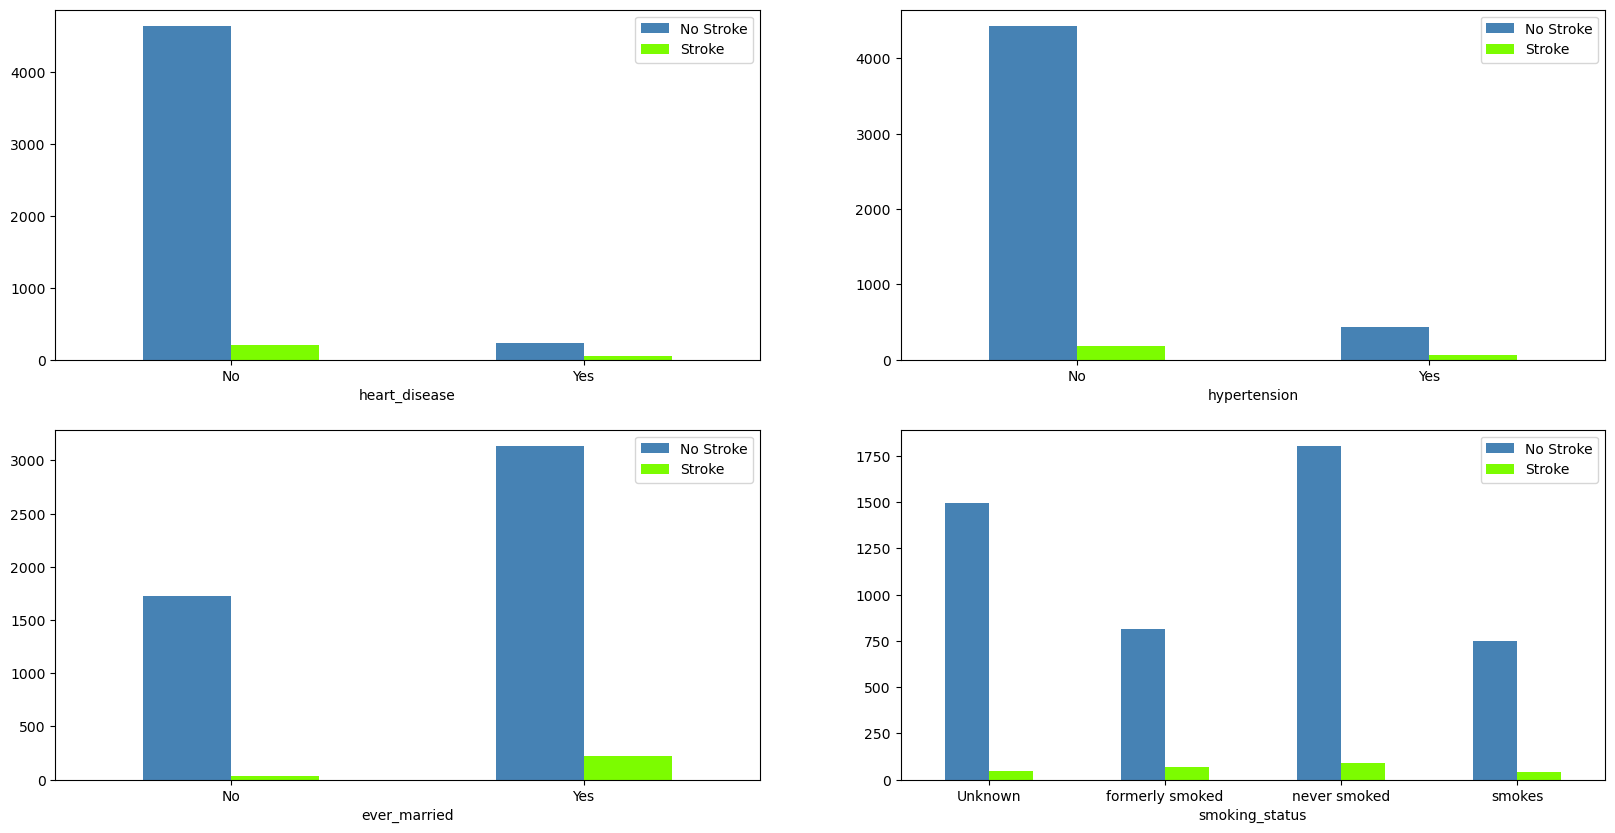

In [15]:
# Creating some crosstab info for some of the remaining columns 
ct1 = pd.crosstab(df.heart_disease,df.stroke)
ct2 = pd.crosstab(df.hypertension,df.stroke)
ct3 = pd.crosstab(df.ever_married,df.stroke)
ct4 = pd.crosstab(df.smoking_status,df.stroke)

# Setting the colors
colors = ["steelblue","lawngreen"]

# Setting up the figure and different axes on the figure
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,
                                          ncols=2, 
                                          figsize=(20,10))

# Plotting each crosstab on a different axis
ct1.plot(kind='bar',ax=ax1,color=colors,rot=0)
ct2.plot(kind='bar',ax=ax2,color=colors,rot=0)
ct3.plot(kind='bar',ax=ax3,color=colors,rot=0)
ct4.plot(kind='bar',ax=ax4,color=colors,rot=0);

# Setting x labels for heart_disease and hypertension
ax1.set_xticklabels(["No","Yes"])
ax2.set_xticklabels(["No","Yes"])

# Changing the lables of the legend
ax1.legend(labels=['No Stroke', 'Stroke'])
ax2.legend(labels=['No Stroke', 'Stroke'])
ax3.legend(labels=['No Stroke', 'Stroke'])
ax4.legend(labels=['No Stroke', 'Stroke']);

I've decided to use subplots to quickly summarize several of the columns. From the first two plots (heart_disease and hypertension), I can infer that people who have these medical conditions seem to have a higher percentage of having a stroke. Right off the bat, I don't see any clear trending patterns within the smoking and married data. It does look like former smokers have a higher percentage chance of having a stroke vs. those who have never smoked, but not dramatically so. If I wasn't trying to save notebook space doing a project, I would dig into this a little deeper.

Finally, let's make a correlation matrix to compare the column values against one another. 

In [16]:
# Making our correlation matrix
df.corr()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,0.003677,0.003610,-0.001253,0.000943,0.003238,0.006430
age,0.003677,1.000000,0.276367,0.263777,0.238323,0.333314,0.245239
hypertension,0.003610,0.276367,1.000000,0.108292,0.174540,0.167770,0.127891
heart_disease,-0.001253,0.263777,0.108292,1.000000,0.161907,0.041322,0.134905
avg_glucose_level,0.000943,0.238323,0.174540,0.161907,1.000000,0.175672,0.131991
bmi,0.003238,0.333314,0.167770,0.041322,0.175672,1.000000,0.042341
stroke,0.006430,0.245239,0.127891,0.134905,0.131991,0.042341,1.000000


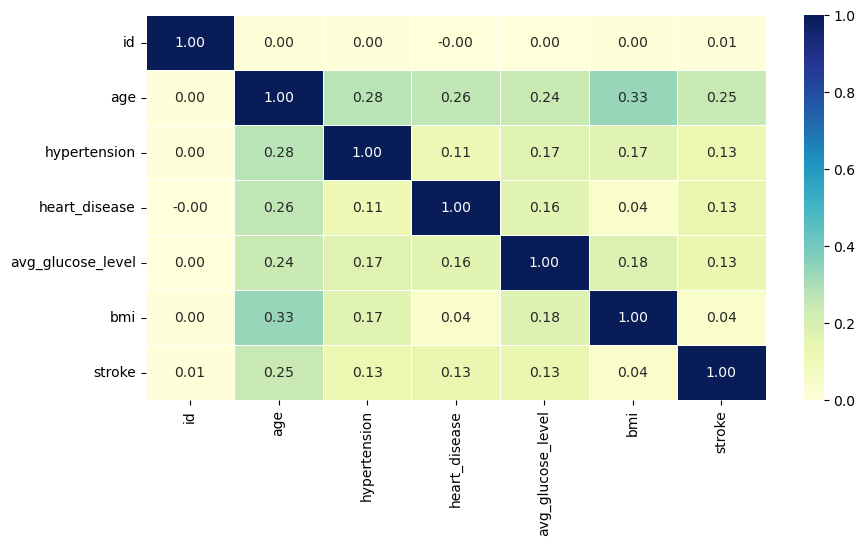

In [17]:
# Let's make the correlation matrix into a heatmap
corr_matrix = df.corr() 
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(corr_matrix,
                 annot=True, 
                 linewidths=0.5,
                 fmt=".2f", 
                 cmap="YlGnBu" 
                );

The only correlation I can really see here is with age and likelihood of having a stroke. While it's not a very strong correlation, age does seem to be a better indicator of having a stroke than any of the other variables. 

I think this is a good place to end our EDA for this notebook. Let's continue on with modeling!

# Data Modeling 

So now that we've done some EDA and gotten to know our data a little better, let's model the data. Before we fill in the missing values and convert the non-numerical columns found in our EDA, I need to prepare the data so there won't be any bias in the machine's evaluation. I'm going to first create X(features) and y(target) values, and then split them into training, validation, and test sets.

In [18]:
# Checking out the df before I split it
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [19]:
# Noticing that I don't need the id column, so I will drop it
df.drop("id",axis=1, inplace=True)

In [20]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [21]:
# Now let's break up our data into X and y values
X = df.drop("stroke", axis=1)
y = df["stroke"]

# Checking the shapes
X.shape, y.shape

((5109, 10), (5109,))

In [22]:
# Creating a random seed to mix the data 
np.random.seed(88)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# Splitting the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25) 

# Making sure our data was split correctly 
len(df), len(X_train), len(X_valid), len(X_test)

(5109, 3065, 1022, 1022)

So in the above cell, we first split our entire data set into 80% for training and 20% for testing. We then split that 80% for training into 75% for training and 25% for validation. So finally we should have 60% for training, 20% for validation, and 20% for testing. So:

3065/5109 = 59.99% Training 

1022/5109 = 20.00% Validation 

1022/5109 = 20.00% Test 

Perfect!!


Now that the data is split up, let's fill in the missing values and convert all the non-numeric values to numeric ones. 

In [23]:
# Looking at the number of unique, max, and min values for BMI
len(df["bmi"].value_counts()), min(df["bmi"]), max(df["bmi"])

(418, 10.3, 97.6)

In [24]:
# Checking on the mean and median values
df["bmi"].mean(), df["bmi"].median()

(28.894559902200488, 28.1)

Since the mean and median are pretty close, I don't think it matters too much which one I choose to fill in the missing values. There doesn't appear to be any outliers skewing the data in one particular direction or another. 

In [25]:
# Creating a list of our split X values
data_splits = [X_train,X_valid,X_test]

# Function to fill in null values with the median of BMI data
def median_filler(split): 
    """
    Fills in any missing bmi values with the median from the set.
    """
    split["bmi"].fillna(split["bmi"].median(),inplace=True)
    
# Function to convert non-numeric values into numeric ones
def convert_category(split):
    """
    Converts non-numeric values into categories. 
    The categories are then converted to integers via the category code.
    """
    for label, content in split.items():
        if pd.api.types.is_object_dtype(content):
            # First creating categories
            split[label] = content.astype("category").cat.as_ordered()
            
            # Next accessing the corresponding codes for each category
            split[label] = pd.Categorical(content).codes
    
# Looping each X split in our list through the two functions
for split in data_splits:
    median_filler(split)
    convert_category(split)
    
    # Checking null values 
    print(f"Number of nulls: {split['bmi'].isnull().sum()}")

    # Checking datatypes
    print(f"Datatypes:\n{split.dtypes}")
    print("__________________________________")


Number of nulls: 0
Datatypes:
gender                  int8
age                  float64
hypertension           int64
heart_disease          int64
ever_married            int8
work_type               int8
Residence_type          int8
avg_glucose_level    float64
bmi                  float64
smoking_status          int8
dtype: object
__________________________________
Number of nulls: 0
Datatypes:
gender                  int8
age                  float64
hypertension           int64
heart_disease          int64
ever_married            int8
work_type               int8
Residence_type          int8
avg_glucose_level    float64
bmi                  float64
smoking_status          int8
dtype: object
__________________________________
Number of nulls: 0
Datatypes:
gender                  int8
age                  float64
hypertension           int64
heart_disease          int64
ever_married            int8
work_type               int8
Residence_type          int8
avg_glucose_level    float64


Great! I'm glad we were able to fill all of the missing values and convert the non-numeric ones to numeric. I am a little concerned about the mapping though. We've converted all of the objects to categories and then accessed the codes from those categories to make them numeric, but how do I know that across all of the data splits the categories are assigned the same value? I'm fairly new to ML, so I want to double check myself to make sure. After much head scratching, I thought of getting the original df value counts for objects and then comparing that number to the combination of all the X splits value_counts for the corresponding column name. (Hope that makes sense). I've written the code below: 

In [26]:
# Generating a list of the original non-numeric objects 
objects = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

# Empty lists for counted values 
original_count = []
split_count =[]

# Counting the original objects, and the combined split object's values
for object in objects:
    original_count.append(df[object].value_counts())
    
    # Add each split value together
    split_add = 0
    
    for split in data_splits: 
        split_add += split[object].value_counts()
    split_count.append(split_add)

# Checking to make sure that they are equal to each other
for i, obj in enumerate(objects):
    if original_count[i].values.tolist() == split_count[i].values.tolist():
        print(f"All {obj} values were mapped correctly!")
    else:
        print(f"There was a problem with {obj}.")

All gender values were mapped correctly!
All ever_married values were mapped correctly!
All work_type values were mapped correctly!
All Residence_type values were mapped correctly!
All smoking_status values were mapped correctly!


Okay, we're in good shape now! 

Now that are data is all split up and we've taken care of missing and non-numeric values, let's build some machine learning models. There's a handy flowchart produced by Scikit-learn that can help decide which estimator to choose: 

[![ML-Map.png](https://i.postimg.cc/pT9kXWd2/ML-Map.png)](https://postimg.cc/XGb9s0Fh)

I'm going to try 4 different estimators to model the data. Following the above flowchart:

1. I have more than 50 samples

2. I'm predicting a category (stroke or no stroke) 

3. I have labeled data

4. I have less than 100K samples 

    * `Linear SVC` will go on our list. 
    

5. I don't have text data 

    * `KNeighbors Classifier` will go on our list. 

    * `Ensemble Classifier` will go on our list (Random Forest) 

The last one is `Logistic Regression` which, despite it's name, is a linear model for classification. I found this one through searching for "best machine learning models for classification problems" online.

Now that we've figured out which estimators we are going to use, let's fit them and create some models. 

In [27]:
# Put our models in a dictionary 
models = {"Linear SVC": LinearSVC(),
          "KNeighbors": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Logistic Regression": LogisticRegression()}

# Create a funciton that will fit and score the models (based on training and validation sets)
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models. 
    models: a dictionary of different Scikit-Learn machine learning models 
    X_train: training features
    X_valid: validation/test features
    y_train: training labels
    y_valid: validation/test labels
    """
    # Setting a random seed 
    np.random.seed(88)
    
    # Empty dictionary to store model scores
    model_scores = {} 
    
    # Looping through each model
    for name, model in models.items():
        
        # Fit the model 
        model.fit(X_train, y_train)
        
        # Evaluate the model and append it's accuracy score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    
    # Return the model_scores dictionary 
    return model_scores

In [28]:
# Blocking warnings
warnings.filterwarnings("ignore")

# Running the above function and returning our score dictionary 
model_scores = fit_and_score(models,X_train,X_valid,y_train,y_valid)

model_scores

{'Linear SVC': 0.9305283757338552,
 'KNeighbors': 0.9246575342465754,
 'Random Forest': 0.9315068493150684,
 'Logistic Regression': 0.9315068493150684}

All of our models scored quite high on the first run through. I have a sneaking suspicious that this is due to the imbalanced number of target values that we discussed earlier. As a quick reminder, if the machine guessed "No Stroke" for every value, it would achieve 95% accuracy. This goes back to our needing more data with patients who have had a stroke.

# Hyperparameter Tuning

Even though our baseline models have quite high scores, we are still going to try and achieve the 95% accuracy stated in our Evaluation Criteria at the top. To do this, the next step will be tuning hyperparameters. I'll tune the hyperparameters on the `Linear SVC`, `Random Forest`, and `Logistic Regression` models; leaving out `KNeighbors` since it scored lower than the others. I'm going to start by running hyperparameters through a Randomized Search and then we will move our top performing model to a Grid Search to check against all combinations of hyperparameters. First we need to create grids of hyperparameters for each of our models. 

**Note**: I found all of these hyperparameters by searching online for the best tuning hyperparameters for each different estimator. I've made random guesses based on others' recommendations online.

In [29]:
# Creating hyperparameter grids 

# Linear SVC grid
lin_svc_grid = {"C": np.logspace(-3, 3, 7),
                   "penalty": ["l1","l2"],
                   "loss": ["hinge","squared_hinge","modified_huber"]}

# Random Forest grid 
rand_for_grid = {"n_estimators": np.arange(10,1000,50),
                "max_depth": [None, 3, 5, 10],
                "min_samples_split": np.arange(2,20,2)}

# Logictic Regression grid
log_reg_grid = {"C": np.logspace(-4,4,20),
                "penalty": ["l1","l2"],
                "solver": ["liblinear","lbfgs"]}

# List of grids
all_grids = [lin_svc_grid, rand_for_grid, log_reg_grid]

# Recreating our dictionary to only include models we want to use and adding grids for the models 
models = {"Linear SVC": [LinearSVC(),lin_svc_grid],
          "Random Forest": [RandomForestClassifier(),rand_for_grid],
          "Logistic Regression": [LogisticRegression(),log_reg_grid]
                                  }

In [30]:
# Tuning our models 

# Blocking all of the numerous warnings
warnings.filterwarnings("ignore")

# Creating a random seed
np.random.seed(88)

# Creating a function to run the randomizedgrid
def randomized_tune(models,X_train,y_train): 
    """
    Randomly chooses hyperparameters from the grid and fits them to a model.
    Returns the best hyperparameters.
    """ 
    # Empty dictionary for trained(fit) models 
    rs_models ={}
    
    for name, model in models.items(): 
        
        # Running RandomizedSearch Cross Validation on each model using a random subsect of given hyperparameters 
        rs_model = RandomizedSearchCV(model[0],
                                      param_distributions=model[1],
                                      cv=5, 
                                      n_iter=20,
                                      verbose=0)
        rs_model.fit(X_train,y_train)
        rs_models[name]=rs_model
    
    return rs_models

# Running our models through the Randomized tuning
rs_models = randomized_tune(models,X_train,y_train)

# Returning the new scores 
for name, model in rs_models.items():
    print(f"These are the best parameters found for {name}:\n{model.best_params_}")
    print(f"Score after using best hyperparameters:\n{name}:{model.score(X_valid,y_valid)}")
    print("---------------------")

These are the best parameters found for Linear SVC:
{'penalty': 'l2', 'loss': 'squared_hinge', 'C': 1000.0}
Score after using best hyperparameters:
Linear SVC:0.9305283757338552
---------------------
These are the best parameters found for Random Forest:
{'n_estimators': 860, 'min_samples_split': 18, 'max_depth': 3}
Score after using best hyperparameters:
Random Forest:0.9305283757338552
---------------------
These are the best parameters found for Logistic Regression:
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.23357214690901212}
Score after using best hyperparameters:
Logistic Regression:0.9295499021526419
---------------------


In [31]:
# Baseline model scores
print("Baseline Scores:")
model_scores

Baseline Scores:


{'Linear SVC': 0.9305283757338552,
 'KNeighbors': 0.9246575342465754,
 'Random Forest': 0.9315068493150684,
 'Logistic Regression': 0.9315068493150684}

Well after running through the RandomGridCV, we can conclude:

* `Linear SVC` hasn't changed it's score

* `Random Forest` has decreased it's score 

* `Logistic Regression` has decreased it's score the most

Hmm...this randomized search didn't prove to very fruitful. Perhaps we should choose our top performing models and run them through a full grid search. Normally I would pick our top performing model to run a Grid Search on but in this case `Random Forest` and `Logistic Regression` are pretty neck and neck. For the sake of time, I'm just going to choose one model to run through the full GridSearchCV. Let's try running `Logistic Regression` through GridSearchCV. 

In [32]:
# Updating our log_reg_grid for a more exhaustive search 
log_reg_grid = {"C": np.logspace(-4,4,30),
                "penalty": ["l1","l2"],
                "solver": ["liblinear","lbfgs","sag"]}

# Using GridSearch
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5)

# Fitting our model
gs_log_reg.fit(X_train, y_train)

# Results
print(f"Best Parameters for Log Reg:\n{gs_log_reg.best_params_}")
print(f"Grid Search score Log Reg:\n{gs_log_reg.score(X_valid,y_valid)}")
print(f"Baseline score for Log Reg:\n{model_scores['Logistic Regression']}")

Best Parameters for Log Reg:
{'C': 0.20433597178569418, 'penalty': 'l2', 'solver': 'lbfgs'}
Grid Search score Log Reg:
0.9305283757338552
Baseline score for Log Reg:
0.9315068493150684


Even after our exhaustive grid search, we still couldn't beat the baseline score value for Logistic Regression. I think 93.15% is about as high as we are going to be able to get with the validation data. In real life I would tinker with this more and try different models and hyperparameters to try and get my score up to our Evaluation goal of 95%. For the sake of this notebook, we're going to keep moving on. Hopefully the test data will perform better.

Now that we've tuned hyperparameters and determined our best models, it's time to run our test data through the model to see what kind of score we can get. Since tuning hyperparameters actually seemed to make our scores worse, I'm just going to use the original baseline models.

Let's run the test data through all of the original models.


In [33]:
# Revisiting our dictionary
models = {"Linear SVC": LinearSVC(),
          "KNeighbors": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Logistic Regression": LogisticRegression()}

# Calling our function we made to test the data earlier
test_scores = fit_and_score(models, X_train, X_test, y_train, y_test)

test_scores

{'Linear SVC': 0.9657534246575342,
 'KNeighbors': 0.961839530332681,
 'Random Forest': 0.9628180039138943,
 'Logistic Regression': 0.9637964774951077}

# Evaluation

Well would you look at that! We reached our threshold of 95% on all of the models! However, it does seem a little suspicious that all of the models raised their accuracy by 3% on the test data.

Let's look at some evaluation metrics on the data. Since Linear SVC actually ended up being the highest scorer, I'm going to make predictions on that model. 

In [34]:
# Instantiating a separate Linear SVC class
clf = LinearSVC()

# Fitting the model
clf.fit(X_train,y_train)

# Scoring it to make sure it matches above
clf.score(X_test,y_test)

0.9657534246575342

In [35]:
# Making predictions with our top model 
y_preds = clf.predict(X_test)

# What the machine predicted for the target values
y_preds

array([0, 0, 0, ..., 0, 0, 0])

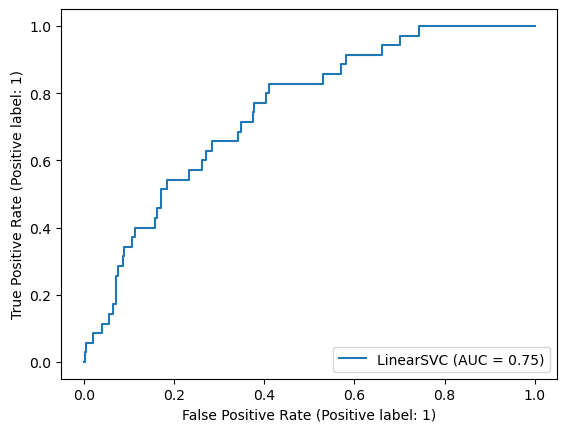

In [36]:
# ROC curve and AUC 
plot_roc_curve(clf,X_test,y_test);

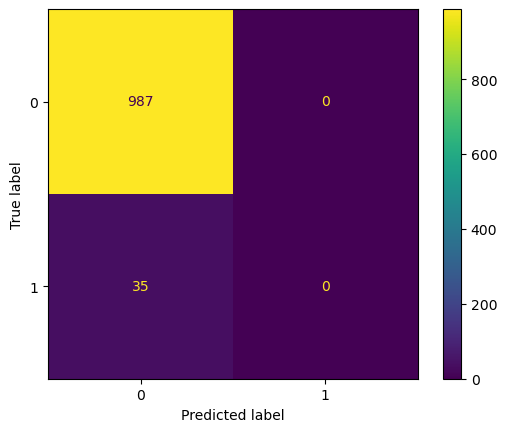

In [37]:
# Let's check out the confusion matrix 
plot_confusion_matrix(clf,X_test,y_test)

Ouch...this confusion matrix is showing that our model isn't performing wonderfully. The ROC curve doesn't look too great either; I would prefer it a little closer to the top left corner there. From our confusion matrix, it looks like our model just predicted "No Stroke" for every single test value.  I suspect this all goes back to our imbalanced number of target variables. With our current data, we really can't get an accurate prediction. We need to gather more data that has instances of patients having a Stroke to make some better insights here. 

In [38]:
# Classification Report 
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       987
           1       0.00      0.00      0.00        35

    accuracy                           0.97      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.93      0.97      0.95      1022



In [39]:
# Creating a function to score precision, recall, and f1 scores with cross validation 
metrics = ["precision","recall","f1"]

def cv_scores(metrics): 
    """
    Performs cross validation on the data and returns the mean score.
    """
    for metric in metrics:
        scores = cross_val_score(clf, X, y, cv=5, scoring=metric)
        print(f"{metric}: {scores.mean():.3f}")
        
        
cv_scores(metrics)

precision: nan
recall: nan
f1: nan


Since we have zero true positives, we aren't able to predict the metrics for precision, recall, and f1. A division by zero won't yield any results. This goes back to our model just predicting "No Stroke" for every item in the test set. 

Finally, let's look at the coefficient and feature importances.

In [40]:
# Check coefficient
clf.coef_

array([[-0.02674639,  0.00589658,  0.10781624,  0.05872669, -0.09386635,
         0.01985006, -0.00661702, -0.00106318, -0.00206701, -0.00781206]])

In [41]:
# Mapping coefficients to columns
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))

feature_dict

{'gender': -0.026746392173944384,
 'age': 0.005896578006243852,
 'hypertension': 0.10781623599036627,
 'heart_disease': 0.05872668926242799,
 'ever_married': -0.09386634715025659,
 'work_type': 0.019850063741275095,
 'Residence_type': -0.006617020066506198,
 'avg_glucose_level': -0.0010631773769097814,
 'bmi': -0.0020670090942745607,
 'smoking_status': -0.007812056021623362}

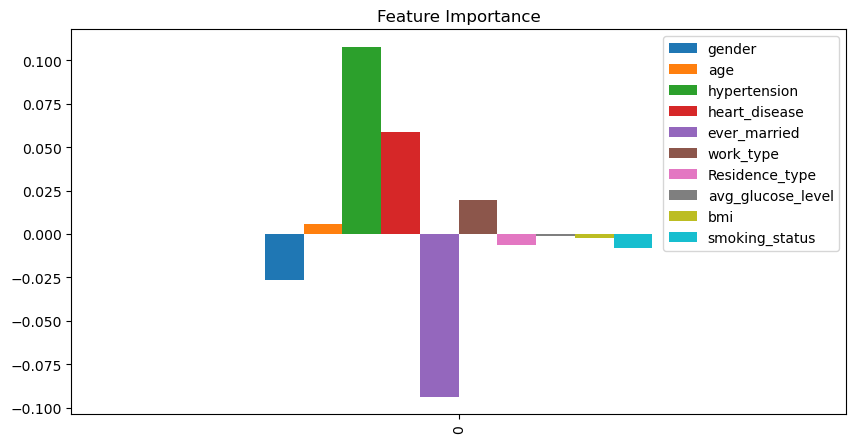

In [42]:
# Visualizing Feature Importance 
feature_df = pd.DataFrame(feature_dict,index=[0])

feature_df.plot.bar(title="Feature Importance",figsize=(10,5));

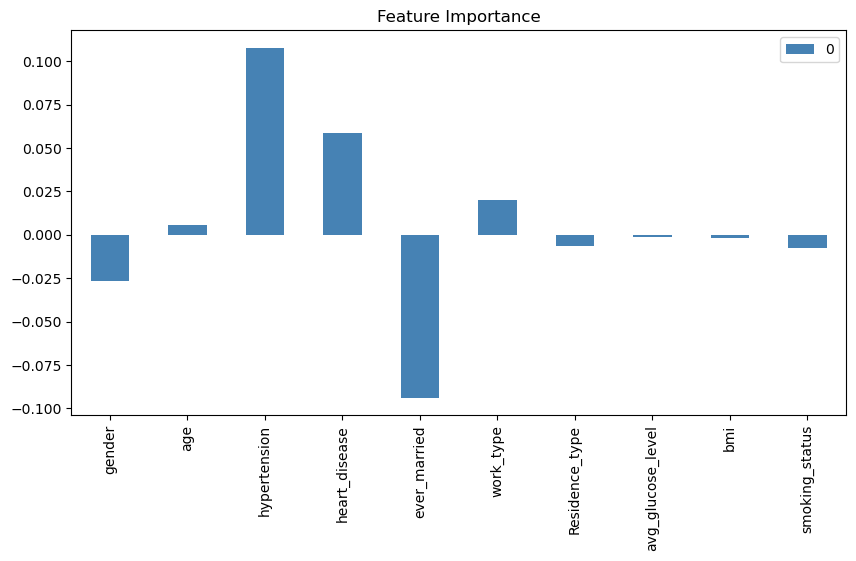

In [43]:
# Let's try transposing it 
feature_df.T.plot.bar(title="Feature Importance", figsize=(10,5), color="Steelblue");

So it looks like hypertension, heart_disease, and ever_married (interesting) had the biggest impact on our model's predictions. 

# Conclusion

Well I know this might seem anticlimactic, but my conclusion is that I need more data. Specifically, more data with instances of patients who **have had** a Stroke. I think all of the No Stroke data biased my machine learning model. Since 95% of the target values had a value of "No Stroke" the model(s) couldn't properly make predictions.

I've really enjoyed this machine learning project. Please let me know if you have any suggestions in the comments below about ideas to improve my models. Thanks!